In [40]:
import os
os.environ['THEANO_FLAGS']="device=gpu2"

%matplotlib inline
from matplotlib import pylab as plt
import theano
from theano import tensor as T
import numpy as np

In [249]:
#create a regular grid in weight space for visualisation
wmin = -5
wmax = 5
wrange = np.linspace(wmin,wmax,300)
w = np.repeat(wrange[:,None],300,axis=1)
w = np.concatenate([[w.flatten()],[w.T.flatten()]])

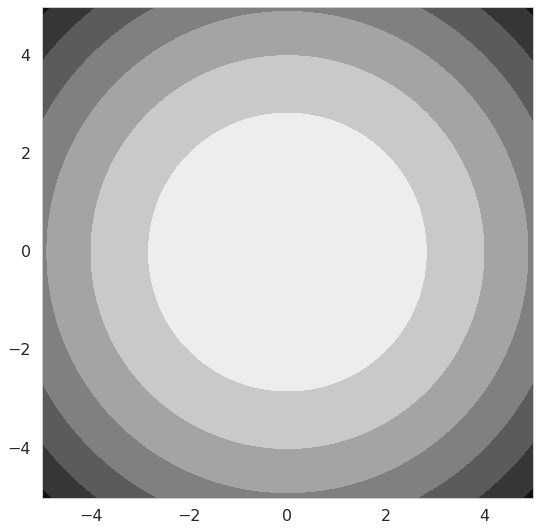

In [297]:
prior_variance = 2
logprior = -(w**2).sum(axis=0)/2/prior_variance
plt.contourf(wrange, wrange, logprior.reshape(300,300), cmap='gray');
plt.axis('square');
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax]);

In [298]:
#generating a toy dataset with three manually selected observations
from scipy.stats import logistic
sigmoid = logistic.cdf
logsigmoid = logistic.logcdf

def likelihood(w,x,b=0,y=1):
    return logsigmoid(y*(np.dot(w.T,x) + b)).flatten()


x1 = np.array([[1.5],[1]])
x2 = np.array([[-1.5],[1]])
x3 = np.array([[0.5],[-1]])

y1=1
y2=1
y3=-1

llh1 = likelihood(w, x1, y=y1) 
llh2 = likelihood(w, x2, y=y2) 
llh3 = likelihood(w, x3, y=y3)

In [299]:
#calculating unnormalised log posterior
#this is only for illustration
logpost = llh1 + llh2 + llh3 + logprior

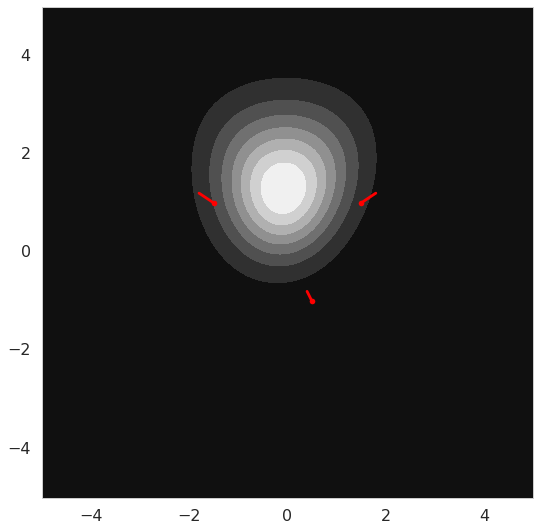

In [300]:
#plotting the real log posterior
#the red dots show the three datapoints, the small line segments shows the direction
#in which the corresponding label shifts the posterior. Positive datapoints shift the 
# posterior away from zero in the direction of the datapoint, negative datapoints shift
# away from zero, in the opposite direction.

plt.contourf(wrange,
             wrange,
             np.exp(logpost.reshape(300,300).T),cmap='gray');
plt.axis('square');
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax])

plt.plot(x1[0],x1[1],'.r')
plt.plot([x1[0],x1[0]*(1+0.2*y1)],[x1[1],x1[1]*(1+0.2*y1)],'r-')

plt.plot(x2[0],x2[1],'.r')
plt.plot([x2[0],x2[0]*(1+0.2*y2)],[x2[1],x2[1]*(1+0.2*y2)],'r-')

plt.plot(x3[0],x3[1],'.r')
plt.plot([x3[0],x3[0]*(1+0.2*y3)],[x3[1],x3[1]*(1+0.2*y3)],'r-');

## Fitting an approximate posterior

This part is for the actual GAN stuff. Here we define the generator and the discriminator networks in Lasagne, and code up the two loss functions in theano.

In [214]:
from lasagne.utils import floatX

from lasagne.layers import (
    InputLayer,
    DenseLayer,
    NonlinearityLayer)
from lasagne.nonlinearities import sigmoid

#defines a 'generator' network
def build_G(input_var=None, num_z = 3):
    
    network = InputLayer(input_var=input_var, shape=(None, num_z))
    
    network = DenseLayer(incoming = network, num_units=10)
    
    network = DenseLayer(incoming = network, num_units=20)
    
    network = DenseLayer(incoming = network, num_units=2, nonlinearity=None)
    
    return network

#defines the 'denoiser network'
def build_denoiser(input_var=None):

    network = InputLayer(input_var=input_var, shape = (None, 2))
    
    network = DenseLayer(incoming = network, num_units=20)
    
    network = DenseLayer(incoming = network, num_units=10)
    
    network = DenseLayer(incoming = network, num_units=20)
    
    network = DenseLayer(incoming = network, num_units=2, nonlinearity=None)
    
    return network
    

In [509]:
from lasagne.layers import get_output, get_all_params
from theano.printing import debugprint
from lasagne.updates import adam
from theano.tensor.shared_randomstreams import RandomStreams
from lasagne.objectives import squared_error

#variables for input (design matrix), output labels, GAN noise variable, weights
x_var = T.matrix('design matrix')
y_var = T.vector('labels')
z_var = T.matrix('GAN noise')
w_var = T.matrix('weights')

#theano variables for things like batchsize, learning rate, etc.
batchsize_var = T.scalar('batchsize', dtype='int32')
prior_variance_var = T.scalar('prior variance')
noise_variance_var = T.scalar('noise variance')
learningrate_var = T.scalar('learning rate')

#random numbers for sampling from the variational distribution
srng = RandomStreams(seed=1337)
z_rnd = srng.normal((batchsize_var,3))
epsilon_rnd = T.sqrt(noise_variance_var)*srng.normal((batchsize_var,2))

#instantiating the G and denoiser networks
generator = build_G(z_var)
denoiser = build_denoiser()

#these expressions are random samples from the variational distribution respectively
samples_from_generator = get_output(generator, z_rnd)
noisy_samples_from_generator = samples_from_generator + epsilon_rnd

#denoiser output for synthetic samples and noisy synthetic samples
denoised_noisy_samples_from_generator = get_output(denoiser, inputs=noisy_samples_from_generator)
denoised_samples_from_generator = get_output(denoiser, inputs=samples_from_generator)

#loss of discriminator - simple binary cross-entropy loss
loss_denoiser = squared_error(samples_from_generator, denoised_noisy_samples_from_generator).mean()

#log likelihood for each synthetic w sampled from the generator
log_likelihood = T.log(
    T.nnet.sigmoid(
        (y_var.dimshuffle(0,'x','x')*(x_var.dimshuffle(0,1,'x') * samples_from_generator.dimshuffle('x', 1, 0))).sum(1)
    )
).sum(0).mean()

#log prior for synthetic w sampled from the generator
log_prior = -((samples_from_generator**2).sum(1)/2/prior_variance_var).mean()

params_G = get_all_params(generator, trainable=True)

#calculating the derivative of the entropy with respect to parameters of G, using theano's Lop
dHdG = (samples_from_generator - denoised_samples_from_generator)/noise_variance_var
dHdPhi = T.Lop(
    f = samples_from_generator.flatten()/batchsize_var,
    wrt = params_G,
    eval_points=dHdG.flatten())

#calculating gradients of other terms in the bound and summing it all up
dLikelihooddPhi = T.grad(log_likelihood, wrt=params_G)

dPriordPhi = T.grad(log_prior,wrt=params_G)

dLdPhi = [-a-b-c for a,b,c in zip(dHdPhi,dPriordPhi,dLikelihooddPhi)]

updates_G = adam(
    dLdPhi,
    params_G,
    learning_rate=learningrate_var,
)

#compiling theano functions:
evaluate_generator = theano.function(
    [z_var],
    get_output(generator),
    allow_input_downcast=True
)

sample_generator = theano.function(
    [batchsize_var],
    samples_from_generator,
    allow_input_downcast=True,
)

params_denoiser = get_all_params(denoiser, trainable=True)

updates_denoiser = adam(
    loss_denoiser,
    params_denoiser,
    learning_rate = learningrate_var
)

train_denoiser = theano.function(
    [batchsize_var, noise_variance_var, learningrate_var],
    loss_denoiser,
    updates = updates_denoiser,
    allow_input_downcast = True
)

train_G = theano.function(
    [x_var, y_var, prior_variance_var, noise_variance_var, batchsize_var, learningrate_var],
    [],
    updates = updates_G,
    allow_input_downcast = True
)

grad_comp_1 = theano.clone(dHdG, replace={samples_from_generator: w_var})/batchsize
grad_comp_2 = T.grad(theano.clone(log_prior, replace={samples_from_generator: w_var}), wrt=w_var)
grad_comp_3 = T.grad(theano.clone(log_likelihood, replace={samples_from_generator: w_var}), wrt=w_var)

    
evaluate_gradients_G = theano.function(
    [w_var, x_var, y_var, prior_variance_var, noise_variance_var],
    [grad_comp_1 + grad_comp_2 + grad_comp_3, grad_comp_1, grad_comp_2, grad_comp_3],
    allow_input_downcast = True
)

evaluate_denoiser = theano.function(
    [w_var],
    get_output(denoiser, w_var),
    allow_input_downcast = True
)

#this is to evaluate the log-likelihood of an arbitrary set of w
llh_for_w = T.nnet.sigmoid((y_var.dimshuffle(0,'x','x')*(x_var.dimshuffle(0,1,'x') * w_var.dimshuffle('x', 1, 0))).sum(1))

evaluate_loglikelihood = theano.function(
        [x_var, y_var, w_var],
        llh_for_w,
        allow_input_downcast = True
    )

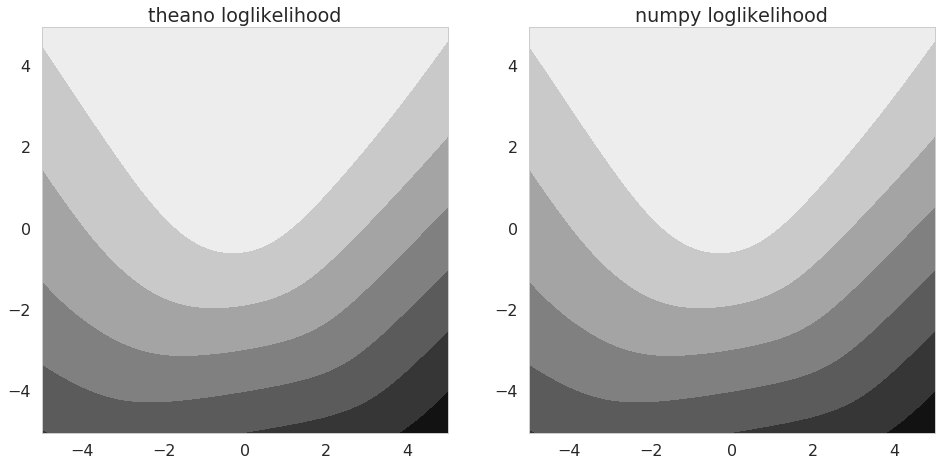

In [510]:
#checking that theano and numpy give the same likelihoods
import seaborn as sns
sns.set_context('poster')

X_train = np.concatenate([x1,x2,x3],axis=1).T
y_train = np.array([y1,y2,y3])
llh_theano = evaluate_loglikelihood(X_train, y_train, w.T)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.contourf(wrange, wrange ,np.log(llh_theano).sum(0).reshape(300,300).T,cmap='gray');
plt.axis('square');
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax])
plt.title('theano loglikelihood')

plt.subplot(1,2,2)
plt.contourf(wrange, wrange, (llh1+llh2+llh3).reshape(300,300).T,cmap='gray');
plt.axis('square');
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax])
plt.title('numpy loglikelihood')

assert np.allclose(llh1+llh2+llh3,np.log(llh_theano).sum(0))

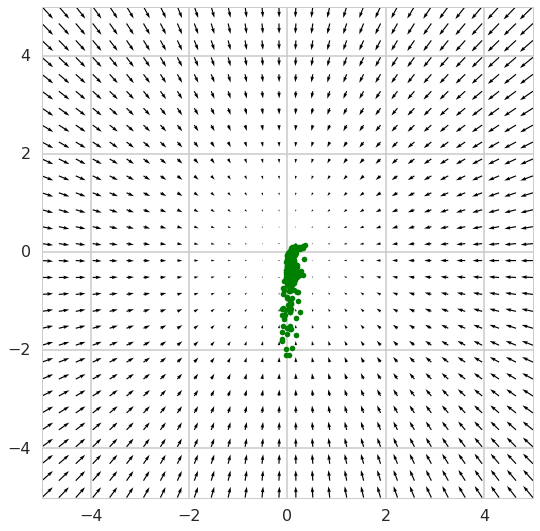

In [511]:
#q and the denoiser before training:
wrange_spaced = np.linspace(wmin,wmax,30)
w_spaced = np.repeat(wrange_spaced[:,None],30,axis=1)
w_spaced = np.concatenate([[w_spaced.flatten()],[w_spaced.T.flatten()]])
arrows = evaluate_denoiser(w_spaced.T) - w_spaced.T
plt.quiver(w_spaced[0,:],w_spaced[1,:],arrows[:,0],arrows[:,1])
W = sample_generator(200)
plt.plot(W[:,0],W[:,1],'g.')
plt.axis('square')
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax]);

In [512]:
batchsize = 100
KARPATHY_CONSTANT = 3e-4
learning_rate = KARPATHY_CONSTANT*10

prior_variance = 1

#pre-training on large noise to avoid spurious modes
noise_variance = 0.7
# train discriminator for some time before starting iterative process
for i in range(5):
    %timeit -n 200 train_denoiser(batchsize, noise_variance, learning_rate)
    print(train_denoiser(batchsize*10, noise_variance, learning_rate))

noise_variance = 0.1
# train discriminator for some time before starting iterative process
for i in range(10):
    %timeit -n 200 train_denoiser(batchsize, noise_variance, learning_rate)
    print(train_denoiser(batchsize*10, noise_variance, learning_rate))

200 loops, best of 3: 1.39 ms per loop
0.08216796070337296
200 loops, best of 3: 1.38 ms per loop
0.10166458785533905
200 loops, best of 3: 1.39 ms per loop
0.0914674922823906
200 loops, best of 3: 1.4 ms per loop
0.09165020287036896
200 loops, best of 3: 1.41 ms per loop
0.08739049732685089
200 loops, best of 3: 1.39 ms per loop
0.03341846913099289
200 loops, best of 3: 1.38 ms per loop
0.03516167402267456
200 loops, best of 3: 1.39 ms per loop
0.03585590049624443
200 loops, best of 3: 1.39 ms per loop
0.03259558603167534
200 loops, best of 3: 1.39 ms per loop
0.03333032503724098
200 loops, best of 3: 1.39 ms per loop
0.03389334678649902
200 loops, best of 3: 1.39 ms per loop
0.033346012234687805
200 loops, best of 3: 1.39 ms per loop
0.03414909914135933
200 loops, best of 3: 1.39 ms per loop
0.03200623765587807
200 loops, best of 3: 1.39 ms per loop
0.032203223556280136


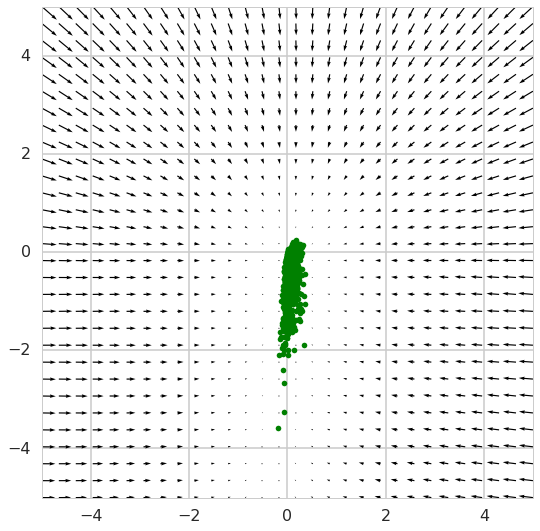

In [513]:
#q and denoiser after training the denoiser:
arrows = evaluate_denoiser(w_spaced.T) - w_spaced.T
plt.quiver(w_spaced[0,:],w_spaced[1,:],arrows[:,0],arrows[:,1])
W = sample_generator(1000)
plt.plot(W[:,0],W[:,1],'g.')
plt.axis('square')
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax]);

In [514]:
# this is the main training loop. For each gradient step of G I do 300 gradient steps of the denoiser
print (train_denoiser(batchsize, noise_variance, 0))
for i in range(200):
    %timeit -n 300 train_denoiser(batchsize, noise_variance, learning_rate)
    print (train_denoiser(batchsize, noise_variance, 0))
    train_G(X_train, y_train, prior_variance, noise_variance, batchsize, learning_rate)

0.03396128490567207
300 loops, best of 3: 1.41 ms per loop
0.032568566501140594
300 loops, best of 3: 1.4 ms per loop
0.03608660027384758
300 loops, best of 3: 1.4 ms per loop
0.024923529475927353
300 loops, best of 3: 1.41 ms per loop
0.02488734759390354
300 loops, best of 3: 1.4 ms per loop
0.02942493185400963
300 loops, best of 3: 1.4 ms per loop
0.032803237438201904
300 loops, best of 3: 1.4 ms per loop
0.02923358604311943
300 loops, best of 3: 1.39 ms per loop
0.03560774400830269
300 loops, best of 3: 1.4 ms per loop
0.03074350580573082
300 loops, best of 3: 1.4 ms per loop
0.032162342220544815
300 loops, best of 3: 1.41 ms per loop
0.033999182283878326
300 loops, best of 3: 1.4 ms per loop
0.02323346585035324
300 loops, best of 3: 1.4 ms per loop
0.03073800913989544
300 loops, best of 3: 1.4 ms per loop
0.03788650035858154
300 loops, best of 3: 1.4 ms per loop
0.027118148282170296
300 loops, best of 3: 1.4 ms per loop
0.031182188540697098
300 loops, best of 3: 1.4 ms per loop
0.0

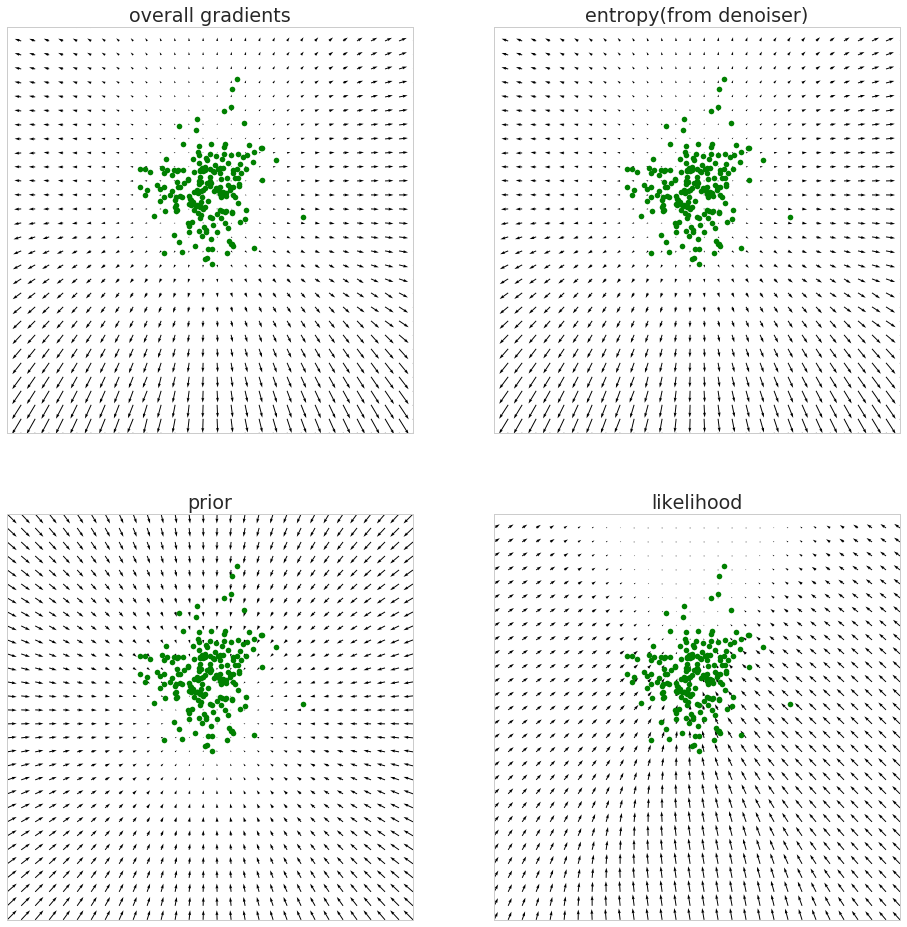

In [515]:
#q and denoiser after training the denoiser:
sns.set_style('whitegrid')
plt.subplots(figsize=(16, 16))
arrows_sum, arrows_1, arrows_2, arrows_3 = evaluate_gradients_G(w_spaced.T, X_train, y_train, prior_variance, noise_variance)
W = sample_generator(200)

plt.subplot(2,2,1)
plt.quiver(w_spaced[0,:],w_spaced[1,:],0.1*arrows_sum[:,0],0.1*arrows_sum[:,1])
plt.plot(W[:,0],W[:,1],'g.')
plt.axis('square')
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax]);
plt.xticks([])
plt.yticks([])
plt.title('overall gradients')

plt.subplot(2,2,2)
plt.quiver(w_spaced[0,:],w_spaced[1,:],arrows_1[:,0],arrows_1[:,1])
plt.plot(W[:,0],W[:,1],'g.')
plt.axis('square')
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax]);
plt.xticks([])
plt.yticks([])
plt.title('entropy(from denoiser)')

plt.subplot(2,2,3)
plt.quiver(w_spaced[0,:],w_spaced[1,:],arrows_2[:,0],arrows_2[:,1])
plt.plot(W[:,0],W[:,1],'g.')
plt.axis('square')
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax]);
plt.xticks([])
plt.yticks([]);
plt.title('prior');

plt.subplot(2,2,4)
plt.quiver(w_spaced[0,:],w_spaced[1,:],arrows_3[:,0],arrows_3[:,1])
plt.plot(W[:,0],W[:,1],'g.')
plt.axis('square')
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax]);
plt.xticks([])
plt.yticks([]);
plt.title('likelihood');

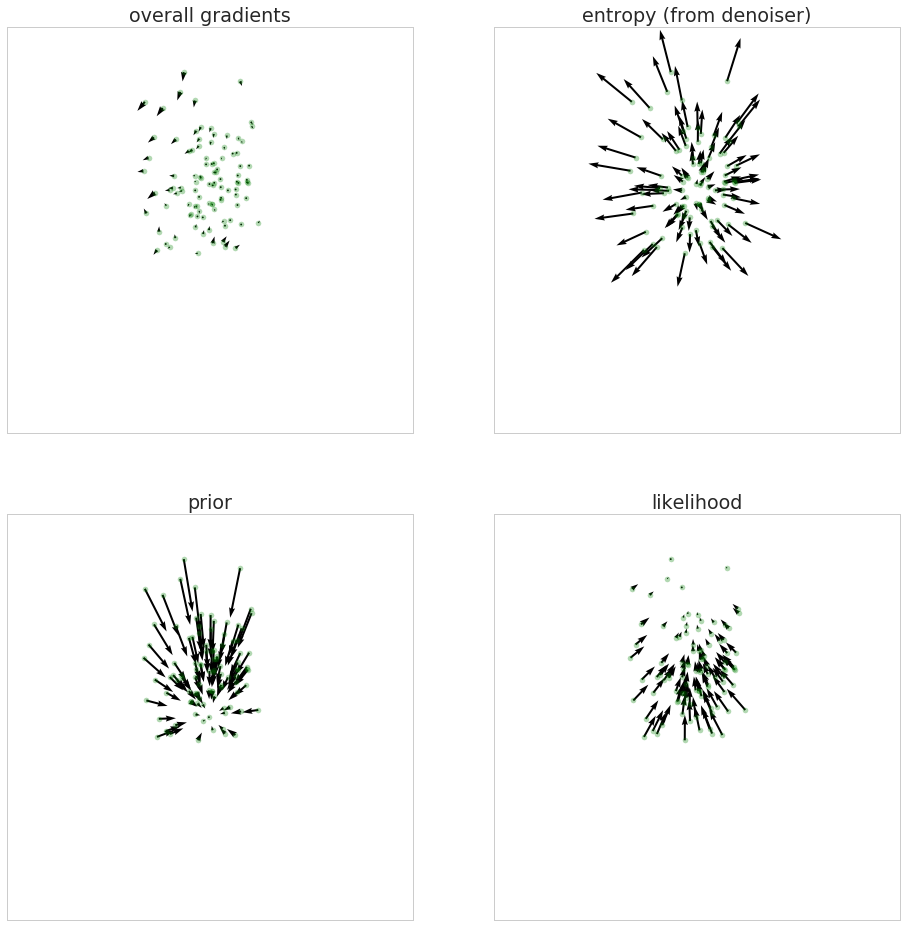

In [516]:
W = sample_generator(100)
arrows_sum, arrows_1, arrows_2, arrows_3 = evaluate_gradients_G(W, X_train, y_train, prior_variance, noise_variance)

sns.set_style('whitegrid')
plt.subplots(figsize=(16,16))
arrow_scale = 3e-1
plt.subplot(2,2,1)
plt.plot(W[:,0],W[:,1],'g.',alpha=0.3)
plt.quiver(W[:,0], W[:,1], arrows_sum[:,0], arrows_sum[:,1], scale = arrow_scale, scale_units='width', width=0.005)
plt.axis('square')
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax]);
plt.xticks([])
plt.yticks([])
plt.title('overall gradients')

plt.subplot(2,2,2)
plt.plot(W[:,0],W[:,1],'g.',alpha=0.3)
plt.quiver(W[:,0], W[:,1], arrows_1[:,0], arrows_1[:,1], scale=arrow_scale, scale_units='width', width=0.005)
plt.axis('square')
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax]);
plt.xticks([])
plt.yticks([])
plt.title('entropy (from denoiser)')

plt.subplot(2,2,3)
plt.plot(W[:,0],W[:,1],'g.',alpha=0.3)
plt.quiver(W[:,0], W[:,1], arrows_2[:,0], arrows_2[:,1], scale = arrow_scale, scale_units='width', width=0.005)
plt.axis('square')
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax]);
plt.xticks([])
plt.yticks([]);
plt.title('prior');


plt.subplot(2,2,4)
plt.plot(W[:,0],W[:,1],'g.',alpha=0.3)
plt.quiver(W[:,0], W[:,1], arrows_3[:,0], arrows_3[:,1], scale = arrow_scale, scale_units='width', width=0.005)
plt.axis('square')
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax]);
plt.xticks([])
plt.yticks([]);
plt.title('likelihood');

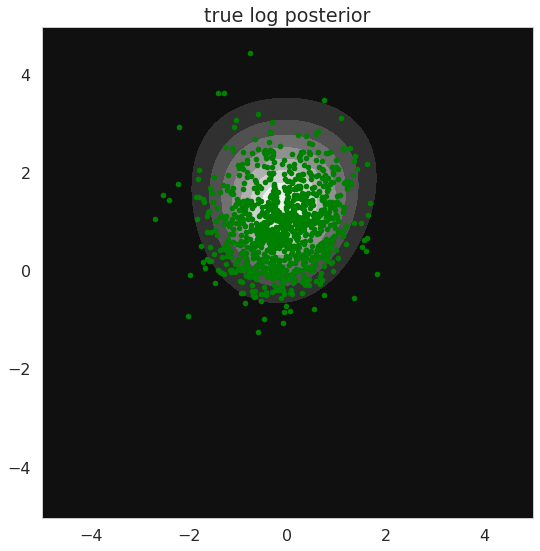

In [517]:
plt.contourf(wrange, wrange, np.exp(logpost.reshape(300,300).T),cmap='gray');
plt.axis('square');
W = sample_generator(1000)
plt.plot(W[:,0],W[:,1],'.g')
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax]);
plt.title('true log posterior');

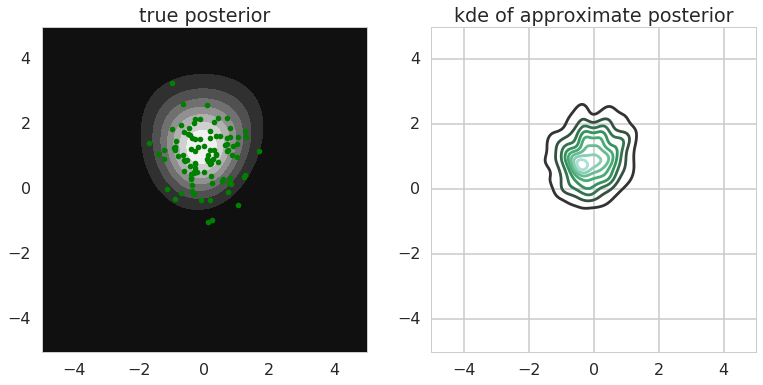

In [518]:
sns.set_style('whitegrid')
plt.subplot(1,2,2)

W = sample_generator(5000)
plot = sns.kdeplot(W[:,0],W[:,1])
plt.axis('square')
plot.set(xlim=(wmin,wmax))
plot.set(ylim=(wmin,wmax))
plt.title('kde of approximate posterior')

plt.subplot(1,2,1)
plt.contourf(wrange, wrange, np.exp(logpost.reshape(300,300).T),cmap='gray');
plt.axis('square');
W = sample_generator(100)
plt.plot(W[:,0],W[:,1],'.g')
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax]);
plt.title('true posterior');

In [520]:
#looking at average gradient magnitudes
#at convergence, the average entropy contribution should be roughly the same as prior and likelihood combined.

W = sample_generator(100)
arrows_sum, arrows_1, arrows_2, arrows_3 = evaluate_gradients_G(W, X_train, y_train, prior_variance, noise_variance)
print('entropy:',(arrows_1**2).mean())
print('log-prior:',(arrows_2**2).mean())
print('log-likelihood:',(arrows_3**2).mean())

entropy: 0.000157828
log-prior: 0.000114875
log-likelihood: 6.52165e-05
